# Filter samples by sharpness level

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Laurence_Fishburne_4.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kate_Capshaw_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Larry_Nichols_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Norman_Mineta_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kweisi_Mfume_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Oliver_Phelps_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube

In [2]:
import torch
import torchvision

In [3]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

   2199    2199   45153


In [4]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
#data_dir = '/kaggle/input/faceid-preprocessed'

In [5]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

videoID      personName  imageHeight  imageWidth  \
0      Alison_Lohman_0   Alison_Lohman        228.0       213.0   
1      Alison_Lohman_1   Alison_Lohman        248.0       201.0   
2      Alison_Lohman_2   Alison_Lohman        335.0       308.0   
3      Alison_Lohman_3   Alison_Lohman        151.0       110.0   
4      Alison_Lohman_4   Alison_Lohman        236.0       228.0   
...                ...             ...          ...         ...   
2189    Yossi_Beilin_3    Yossi_Beilin        240.0       243.0   
2190      Zahir_Shah_0      Zahir_Shah        196.0       200.0   
2191      Zahir_Shah_1      Zahir_Shah        240.0       293.0   
2192  Zoran_Djindjic_0  Zoran_Djindjic        230.0       237.0   
2193  Zoran_Djindjic_2  Zoran_Djindjic        131.0       115.0   

      videoDuration  averageFaceSize  numVideosForPerson  
0             240.0        90.150000                 6.0  
1              79.0       108.417722                 6.0  
2             136.0       122.161765                 6.0  
3              53.0        58.000000                 6.0  
4             147.0        91.680272                 6.0  
...             ...              ...                 ...  
2189          240.0       110.258333                 2.0  
2190          143.0        93.944056                 2.0  
2191          240.0       155.495833                 2.0  
2192          240.0        98.908333                 2.0  
2193          240.0        59.554167                 2.0  

[2194 rows x 7 columns]

In [6]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [7]:
import random
import pickle

random.seed()

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    pfp = self._preprocess(fp)
                    imgs = self._load_preprocessed(pfp)
                    assert len(imgs) == cnt
                    self.preprocessed_cache[fp] = imgs
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def resize(self, anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1, stochastic_set_fraction = 0.8):
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return pfp
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, cache_lim = 1)
len(dataset)

Loading data: 100% 828/828 [00:02<00:00, 366.24it/s]


828

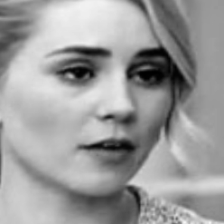

In [8]:
to_pil = torchvision.transforms.ToPILImage()
to_pil(dataset[0][0])

In [9]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [10]:
# https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
def get_sharpness_level(img):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(img, cv2.CV_32F).var()

0.000102046746
0.00013760437
0.0006834535
0.00023411999
0.00010249499
0.000117379015
0.00023492741
0.00023857188
0.00012877538
0.000109301945


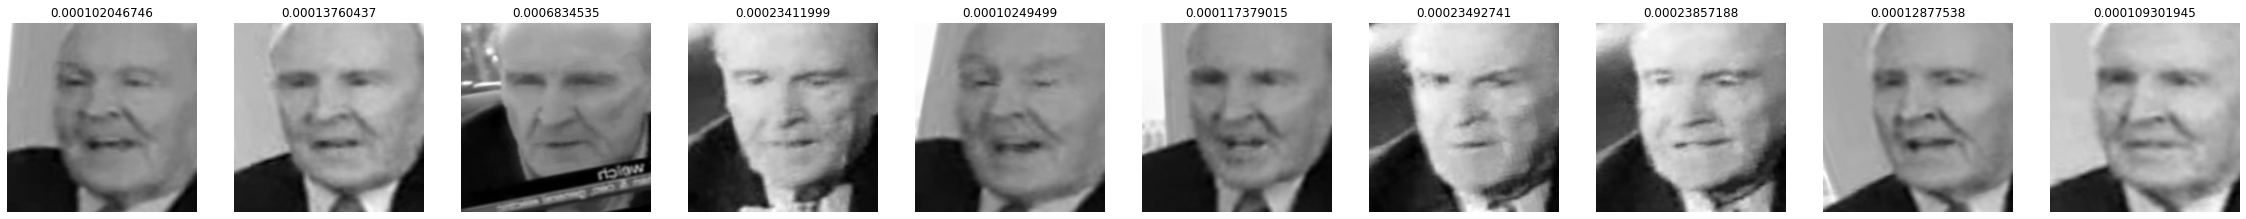

In [11]:
def print_sharpness_levels(img_id):
    cnt = 10
    _, axs = plt.subplots(nrows=1, ncols=cnt, figsize=(cnt*4, 1*4))
    for i in range(cnt):
        img = dataset[img_id][0].detach().reshape(224, 224).numpy()
        title = get_sharpness_level(img)
        plt.sca(axs[i])
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        print(title)

print_sharpness_levels(80)

0.000539521
0.0006173305
0.0005915094
0.0007862242
0.00078290945
0.00021656831
0.0008141222
0.0003366475
0.00041775443
0.00020572369


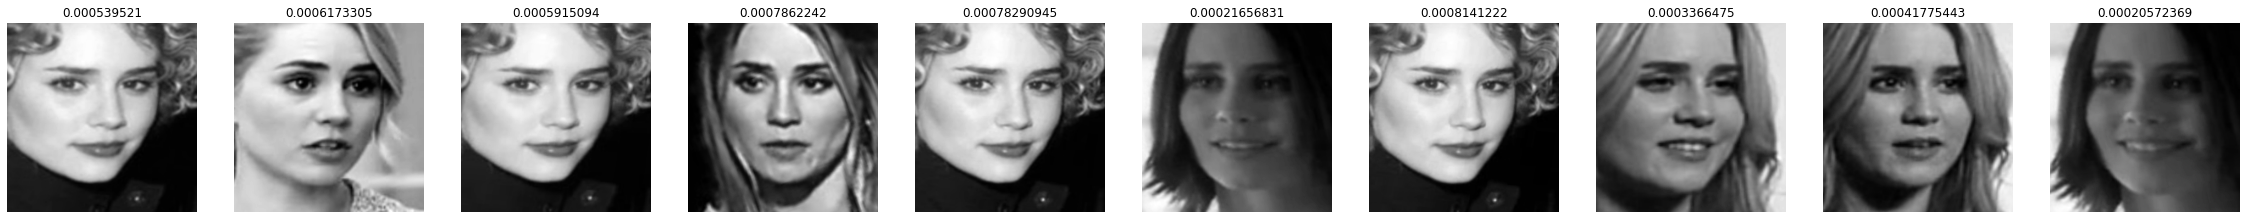

In [12]:
print_sharpness_levels(0)

In [13]:
def validate(model_f, cnt=20, sharpness_level=5e-4):
    model = torch.load(model_f)
    _, axs = plt.subplots(nrows=cnt, ncols=3, figsize=(3*4, cnt*4))
    for i in range(cnt):
        while True:
            idx = random.randint(0, len(dataset)-1)
            img1, img2, img3 = dataset[idx]
            if get_sharpness_level(img1.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            if get_sharpness_level(img2.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            if get_sharpness_level(img3.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            break
        v1 = model(img1.reshape(1, 1, 224, 224)).detach().numpy()
        v2 = model(img2.reshape(1, 1, 224, 224)).detach().numpy()
        v3 = model(img3.reshape(1, 1, 224, 224)).detach().numpy()
        title = '%d %f %f %f %f %f %f' % (idx,
            euc_similarity(v1, v2), euc_similarity(v1, v3),
            cos_similarity(v1, v2), cos_similarity(v1, v3),
            np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())
        plt.sca(axs[i, 0])
        plt.imshow(img1.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.sca(axs[i, 1])
        plt.imshow(img2.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.sca(axs[i, 2])
        plt.imshow(img3.reshape(224, 224), cmap='gray')
        plt.axis('off')
        print(title)

380 2.324490 8.295535 0.943744 0.449201 -6.851125 4.388424
205 3.700449 3.754884 0.227104 0.318302 -2.319869 2.751633
404 2.251367 8.956798 0.977630 -0.587634 -4.439750 4.547718
85 1.901243 13.987041 0.978915 -0.584582 -8.300591 3.245435
778 3.411804 14.734814 0.925828 -0.039040 -9.938015 4.309950
778 1.043177 6.788693 0.994314 0.524751 -4.862834 4.251184
258 4.470924 8.050511 0.808843 0.210682 -5.500469 4.707090
387 1.651189 12.367575 0.974951 -0.076863 -9.396893 4.133153
453 1.956638 8.175103 0.977203 0.463347 -7.416441 3.227863
575 2.887712 2.756979 0.894323 0.929590 -3.481253 4.669462
658 1.588534 14.497397 0.985274 -0.171832 -4.457715 6.401117
465 4.279748 3.467656 0.926813 0.965346 -10.237590 3.349325
539 1.121892 15.055565 0.992621 -0.593143 -6.592394 5.048429
23 2.605929 6.054354 0.966232 0.827396 -8.641888 5.580239
673 3.072677 7.573346 0.962135 0.721640 -5.282751 6.685089
44 0.000000 10.690039 1.000000 0.320877 -9.174297 5.682363
336 1.929268 4.573260 0.938629 0.596505 -2.254

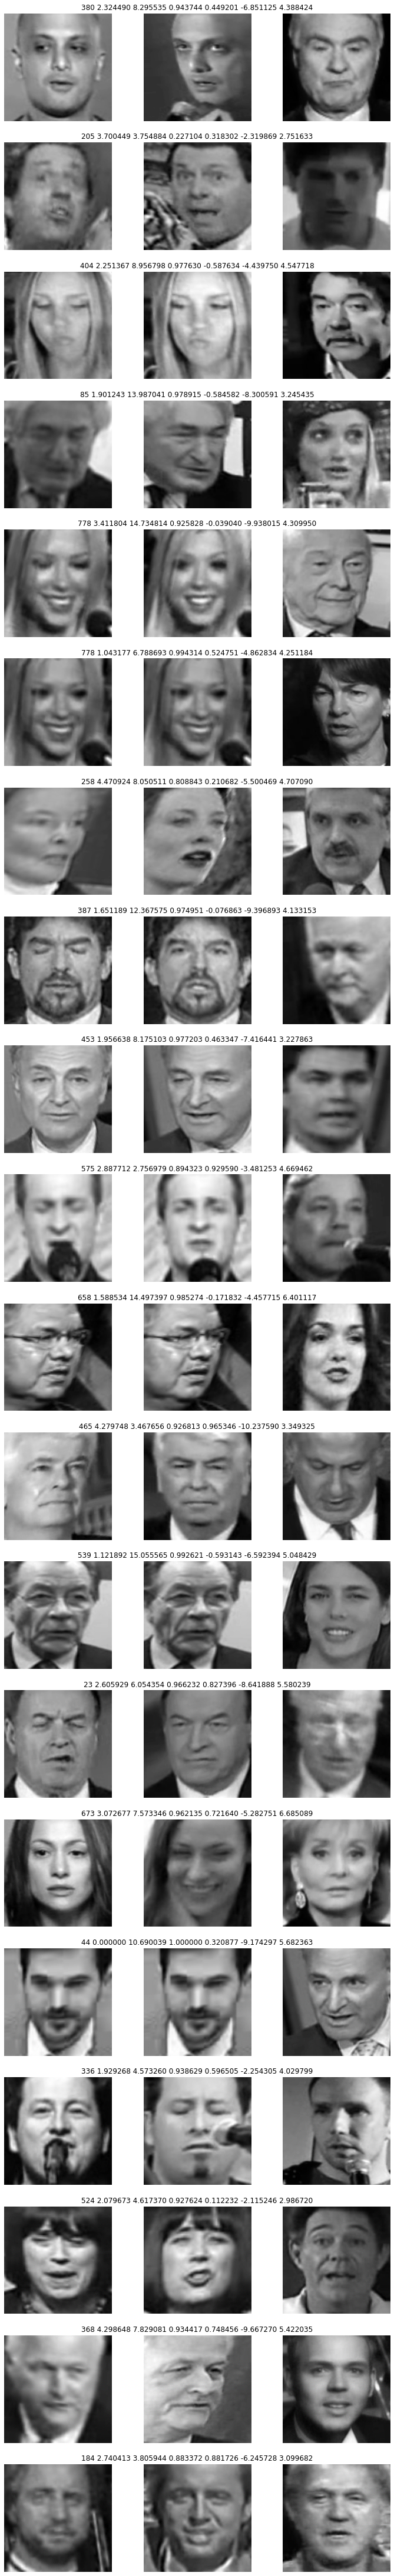

In [14]:
validate('faceid-model-ov8-0.02309628876459473.pt')

240 7.490806 10.350381 0.187438 -0.611362 -2.945561 3.600919
415 1.793049 9.622805 0.967124 -0.150455 -4.705843 5.039934
700 1.860707 7.832345 0.976115 0.480608 -7.362368 4.690723
701 2.768951 5.118164 0.931836 0.931896 -8.971125 3.701209
531 4.635174 8.182567 0.743758 0.552630 -6.938701 5.102531
666 1.594588 4.765827 0.970000 0.740078 -4.940333 3.942990
446 2.334085 5.870180 0.933424 0.535973 -3.785794 3.433581
622 3.438451 5.073446 0.863156 0.657643 -4.004244 4.149027
120 2.649808 13.084209 0.976017 -0.371605 -8.643269 5.471779
807 2.965321 8.630252 0.957172 0.332257 -4.860344 5.147618
484 2.195681 7.866924 0.961267 0.553587 -6.285751 4.130482
31 2.909699 5.784387 0.920377 0.614468 -3.595373 3.846510
572 2.078413 14.160374 0.969007 -0.172535 -9.474329 5.226634
657 2.872511 5.060147 0.598958 0.436957 -2.029138 2.991985
305 1.994639 5.625414 0.940149 0.521873 -3.384718 3.315513
124 1.366311 7.153691 0.978340 0.586954 -7.417984 3.429756
508 0.973455 7.873321 0.963035 0.282609 -4.804056 

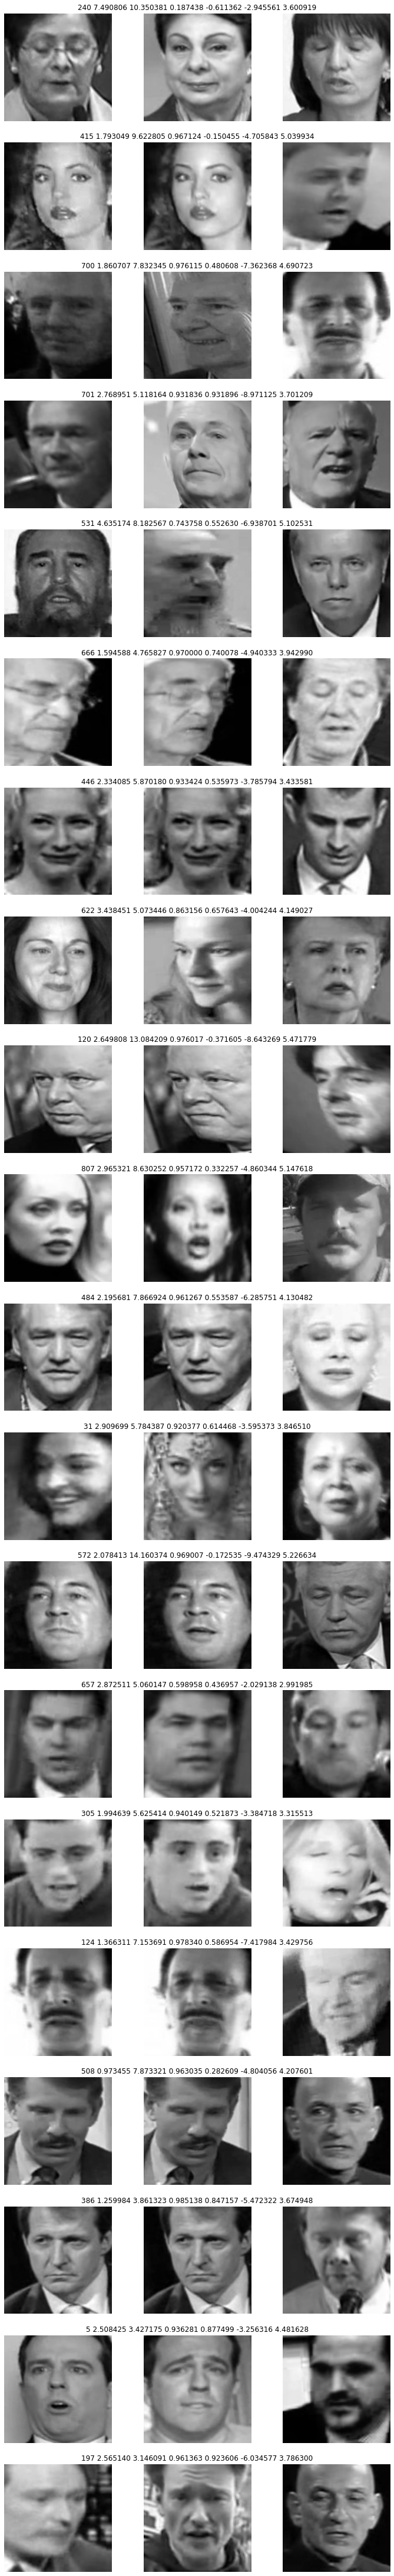

In [15]:
validate('faceid-model-ov8-0.016422454035053595.pt')